# Comparação entre modelos de classificação para Sars-Cov-2

In [2]:
import pandas as pd
import numpy as np
from sklearn.model_selection import GridSearchCV, StratifiedKFold, train_test_split, KFold, learning_curve, ShuffleSplit
from sklearn.neural_network import MLPClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.svm import SVC
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.tree import DecisionTreeClassifier

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Funções principais

In [4]:
def accuracy (y, y_pred):
    count = 0
    for i in range(len(y)):
        if y[i] == y_pred[i]:
             count += 1 
 
    return count / len(y)
    
def recall (y, y_pred):
    tp, fn = 0, 0
    
    for i in range(len(y)):
        if(y[i] == y_pred[i]):
            tp += 1
        else:
            fn += 1
    
    return tp / (tp + fn)
 
def precision (y, y_pred):
    tp, fp = 0, 0
    
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            tp += 1
        elif y[i] == 1 and y_pred[i] == 0:
            fp += 1
    
    return tp / (tp + fp)
 
def F1 (y, y_pred):
    tp, fp, fn = 0, 0, 0
    
    for i in range(len(y)):
        if y[i] == y_pred[i]:
            tp += 1
        elif y[i] == 1 and y_pred[i] == 0:
            fp += 1
        else:
            fn += 1
            
    return tp / (tp + 0.5 * (fp + fn))

In [5]:
def compute_metrics(y, y_pred):
    metrics = {
        'Acurácia': accuracy(y, y_pred), 
        'Precisão': precision(y, y_pred), 
        'Recall': recall(y, y_pred), 
        'F1-Score': F1(y, y_pred)
    }

    return pd.DataFrame(pd.Series(metrics))

In [6]:
class LogisticReg:
    def __init__(self, n_iter=200):
        self.n_iter = n_iter

    def fit(self, X_train, y_train, params, cv):
        self.estimator = LogisticRegression(max_iter=self.n_iter)
        gs = GridSearchCV(estimator=self.estimator, param_grid=params, cv=cv)
        gs.fit(X_train, y_train)
        self.best_params = gs.best_params_

        self.estimator = LogisticRegression(max_iter=self.n_iter, **self.best_params)
        self.estimator.fit(X_train, y_train)
    
    def predict(self, X_test):
        pred = self.estimator.predict(X_test)
        self.best_estimator = self.estimator
        return pred

    def calc_metrics(self, y_test, pred):
        self.metrics = compute_metrics(y_test, pred)
        self.metrics.rename(columns={0: 'Reg. Log.'})

    def plot_metrics(self):
        plt.title('Métricas do Modelo')
        self.metrics.rename(columns={0: 'Reg. Log.'})
        sns.barplot(x=self.metrics.index.to_list(), y=self.metrics[0])
        plt.show()

In [7]:
class SVM:
    def __init__(self, n_iter=200):
        self.n_iter = n_iter

    def fit(self, X_train, y_train, params, cv):
        self.estimator = SVC(kernel='rbf', max_iter=self.n_iter)
        gs = GridSearchCV(self.estimator, param_grid=params, cv=cv)
        gs.fit(X_train, y_train)
        self.best_params = gs.best_params_

        self.estimator = SVC(kernel='rbf', max_iter=self.n_iter, **self.best_params)
        self.estimator.fit(X_train, y_train)

    def predict(self, X_test):
        pred = self.estimator.predict(X_test)
        self.best_estimator = self.estimator
        return pred
    
    def calc_metrics(self, y_test, pred):
        self.metrics = compute_metrics(y_test, pred)
        self.metrics.rename(columns={0: 'SVM'})

    def plot_metrics(self):
        plt.title('Métricas do Modelo')
        self.metrics.rename(columns={0: 'SVM'})
        sns.barplot(x=self.metrics.index.to_list(), y=self.metrics[0])
        plt.show()

In [19]:
class MLP:
    def __init__(self, n_iter=200):
        self.n_iter = n_iter

    def fit(self, X_train, y_train, params, cv):
        self.estimator = MLPClassifier(solver='sgd', max_iter=self.n_iter, verbose=2)

        gs = GridSearchCV(estimator=self.estimator, param_grid=params, cv=cv)
        gs.fit(X_train, y_train)
        self.best_params = gs.best_params_

        self.estimator = MLPClassifier(solver='sgd', max_iter=self.n_iter, **self.best_params)
        self.estimator.fit(X_train, y_train)

    def predict(self, X_test):
        pred = self.estimator.predict(X_test)
        self.best_estimator = self.estimator
        return pred

    def calc_metrics(self, y_test, pred):
        self.metrics = compute_metrics(y_test, pred)
        self.metrics.rename(columns={0: 'MLP'})

    def plot_metrics(self):
        plt.title('Métricas do Modelo')
        self.metrics.rename(columns={0: 'MLP'})
        sns.barplot(x=self.metrics.index.to_list(), y=self.metrics[0])
        plt.show()

## Carregando a base de dados

In [10]:
cols = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/srag_cov_columns.csv', delimiter=';')
columns = cols['Colunas CLASS'].dropna().tolist()

In [37]:
dataset = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/srag_cov_class.csv', sep=',', usecols=columns)

In [39]:
dataset.head()

,CS_SEXO,NU_IDADE_N,TP_IDADE,CS_GESTANT,CS_RACA,CS_ESCOL_N,CO_PAIS,CS_ZONA,SURTO_SG,NOSOCOMIAL,AVE_SUINO,FEBRE,TOSSE,GARGANTA,DISPNEIA,DESC_RESP,SATURACAO,DIARREIA,VOMITO,OUTRO_SIN,PUERPERA,FATOR_RISC,CARDIOPATI,HEMATOLOGI,SIND_DOWN,HEPATICA,ASMA,DIABETES,NEUROLOGIC,PNEUMOPATI,IMUNODEPRE,RENAL,OBESIDADE,OBES_IMC,OUT_MORBI,VACINA,ANTIVIRAL,TP_ANTIVIR,HOSPITAL,UTI,SUPORT_VEN,RAIOX_RES,AMOSTRA,TP_AMOSTRA,PCR_RESUL,POS_PCRFLU,TP_FLU_PCR,POS_PCROUT,PCR_VSR,PCR_PARA1,PCR_PARA2,PCR_PARA3,PCR_PARA4,PCR_ADENO,PCR_METAP,PCR_BOCA,PCR_RINO,PCR_OUTRO,CRITERIO,EVOLUCAO,PCR_SARS2,DOR_ABD,FADIGA,PERD_OLFT,PERD_PALA,TOMO_RES,TP_TES_AN,RES_AN,POS_AN_FLU,TP_FLU_AN,POS_AN_OUT,AN_SARS2,TP_AM_SOR,TP_SOR,RES_IGG,RES_IGM,RES_IGA,VACINA_COV,CLASSI_FIN
0,1,67,3,6,2,9.0,1,1.0,9.0,9.0,9.0,2.0,1.0,2.0,2.0,2.0,2.0,9.0,1.0,2.0,2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,9.0,2.0,2.0,2.0,9.0,1.0,2.0,9.0,9.0,1.0,4.0,4.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,1.0,1.0,9.0,2.0,2.0,2.0,2.0,9.0,9.0,4.0,9.0,9.0,9.0,9.0,1.0,1.0,2.0,2.0,4.0,9.0,1.0
1,1,81,3,6,4,9.0,1,1.0,9.0,9.0,9.0,1.0,9.0,1.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,2,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,1.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,4.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,5.0
2,2,90,3,5,1,9.0,1,2.0,2.0,9.0,2.0,2.0,1.0,2.0,1.0,1.0,1.0,2.0,2.0,2.0,9.0,2,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,2.0,2.0,9.0,1.0,2.0,2.0,9.0,1.0,1.0,5.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,1.0,2.0,9.0,2.0,2.0,2.0,2.0,9.0,2.0,1.0,9.0,9.0,1.0,1.0,9.0,9.0,9.0,9.0,9.0,9.0,5.0
3,1,18,3,6,2,9.0,1,1.0,2.0,2.0,2.0,1.0,1.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,9.0,2,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,2.0,2.0,9.0,1.0,2.0,3.0,6.0,1.0,1.0,1.0,2.0,9.0,1.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,1.0,1.0,1.0,2.0,2.0,2.0,2.0,6.0,9.0,4.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,5.0
4,2,83,3,5,1,9.0,1,1.0,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,1.0,2.0,1,1.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,9.0,2.0,9.0,9.0,9.0,1.0,2.0,3.0,5.0,1.0,1.0,2.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,3.0,1.0,9.0,2.0,2.0,2.0,2.0,2.0,9.0,5.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,9.0,1.0


In [12]:
y = dataset['CLASSI_FIN'].to_numpy()
X = dataset.drop('CLASSI_FIN', axis=1).to_numpy()

scaler = MinMaxScaler()

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=123, test_size=0.2)

scaler.fit(X_train)
X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

skf = KFold(n_splits=5)

## Treinando a Regressão Logística

In [ ]:
params_lr = {'C': [1, 10, 100, 1000, 10000]}
log_reg = LogisticReg(n_iter=100)
log_reg.fit(X_train, y_train, params_lr, skf)
pred_lr = log_reg.predict(X_test)

## Métricas e melhores parâmetros

Melhores parâmetros: {'C': 1}

Métricas:
Acurácia    0.894227
Precisão    1.000000
Recall      0.894227
F1-Score    0.944160
Name: 0, dtype: float64


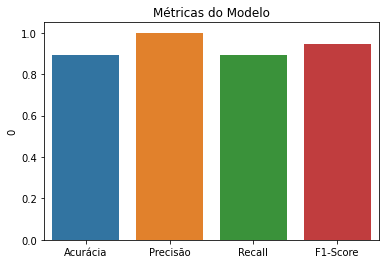

In [133]:
print(f'Melhores parâmetros: {log_reg.best_params}')
print('\nMétricas:')
metrics_lr = log_reg.calc_metrics(y_test, pred_lr)
print(log_reg.metrics[0])
log_reg.plot_metrics()

## Treinando o SVM

In [ ]:
gamma_range = np.array((2e-3, 2e-1, 2e1))
c_range = np.array((2e-1, 2e1, 2e3))

params_svm = dict(gamma=gamma_range, C=c_range)
it = 200
svm = SVM(n_iter=it)
svm.fit(X_train, y_train, params_svm, skf)
pred_svm = svm.predict(X_test)

## Métricas e melhores parâmetros

Melhores parâmetros: {'C': 20.0, 'gamma': 20.0}

Métricas:
Acurácia    0.72643
Precisão    1.00000
Recall      0.72643
F1-Score    0.84154
Name: 0, dtype: float64


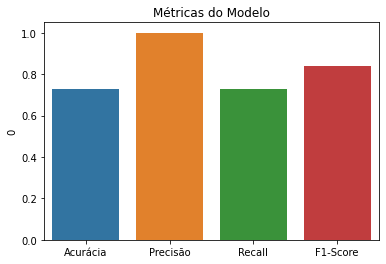

In [140]:
print(f'Melhores parâmetros: {svm.best_params}')
print('\nMétricas:')
metrics_svm = svm.calc_metrics(y_test, pred_svm)
print(svm.metrics[0])
svm.plot_metrics()

## Treinando a Rede Neural

In [ ]:
params_mlp = {'hidden_layer_sizes': [4, 16, 32], 
              'batch_size': [8, 16, 32]
              }

mlp = MLP(n_iter=3)
mlp.fit(X_train, y_train, params_mlp, skf)
pred_mlp = mlp.predict(X_test)

Melhores parâmetros: {'batch_size': 8, 'hidden_layer_sizes': 32}

Métricas:
               MLP
Acurácia  0.934400
Precisão  1.000000
Recall    0.934400
F1-Score  0.966088


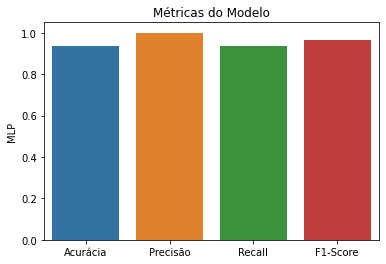

In [25]:
pred_mlp = mlp.predict(X_test)
print(f'Melhores parâmetros: {mlp.best_params}')
print('\nMétricas:')
metrics_mlp = compute_metrics(y_test, pred_mlp)
metrics_mlp.rename(columns={0: 'MLP'}, inplace=True)
print(metrics_mlp)

plt.title('Métricas do Modelo')
sns.barplot(x=metrics_mlp.index.to_list(), y=metrics_mlp['MLP'])
plt.show()

## Tabela de Métricas

In [34]:
df = pd.DataFrame(pd.Series(metrics_lr))
df['SVM'] = metrics_svm.values()
df['MLP'] = metrics_mlp.values()
df.rename(columns={0: 'Reg. Logística'})

,Reg. Logística,SVM,MLP
Acurácia,0.894227,0.72643,0.934400
Precisão,1.000000,1.00000,1.000000
Recall,0.894227,0.72643,0.934400
F1-Score,0.944160,0.84154,0.966088
